# Machine learning helps identifying volume-confounding effects in radiomics
This notebook contains the code used for analysis, as well as to generate the figures in the 2020 *Physica Medica* paper, available [here](https://doi.org/10.1016/j.ejmp.2020.02.010).

Note: the HeadNeckMR dataset is not yet publicly available, and hence not included in the GitHub repository. Please contact the corresponding author for access inquiries.

In [1]:
%matplotlib inline
import os
import tarfile
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, pairwise_logrank_test
from scipy.stats import spearmanr

from joblib import Parallel, delayed
from tqdm import trange


sns.set()
sns.set_context('paper')
sns.set_style('white')

np.random.seed(42)

results_path = './results'

In [2]:
def load_data(root_dir, dataset):
    """Load the clinical and radiomics data for a dataset.
    
    If the dataset is archived, will also uncompress and extract the archive.
    
    Parameters
    ----------
    root_dir : str
        Path to directory where the data files or archive are contained.
    dataset : str
        The name of the dataset. Should correspond to one of directory names
        under `root_dir`.
        
    Returns
    -------
    tuple of pandas.DataFrame
        The clinical information and radiomic features.
    """
    dataset_root = os.path.join(root_dir, dataset)
    if not os.path.exists(dataset_root):
        # try to extract the archive
        with tarfile.open(os.path.normpath(dataset_root) + '.tar.gz') as f:
            f.extractall(dataset_root)
    clinical_path = os.path.join(dataset_root, 'clinical.csv')
    features_path = os.path.join(dataset_root, 'features.csv')
    clinical = pd.read_csv(clinical_path, index_col='patient_id').sort_index()
    features = pd.read_csv(features_path, index_col='patient_id').sort_index()
    clinical['two_year_survival_time'] = np.where(clinical['survival_time'] < 730, clinical['survival_time'], 730)
    return clinical, features

In [3]:
clinical_lung1, features_lung1 = load_data('./data', 'lung1')
clinical_lung1 = clinical_lung1.drop([c for c in clinical_lung1.columns if 'histology' in c], axis=1)

In [4]:
clinical_hn1, features_hn1 = load_data('./data', 'hn1')

In [ ]:
try:
    clinical_hn_mr, features_hn_mr = load_data('./data', 'hn_mr')
except FileNotFoundError:
    warnings.warn(("The HeadNeckMR dataset is not yet publicly accessible, please"
                   " contact the corresponding author with sharing requests."))

## Correlation analysis & removal of redundant features
Section 3.1 in the paper, figure 1.

In [5]:
def feature_correlation(features):
    cor = features.corr(method='spearman')
    upper = cor.where(np.triu(np.ones_like(cor, dtype=np.bool), k=1))
    return upper.abs().max(axis=1) 

def volume_correlation(features):
    return features.corr(method='spearman')['original_shape_Volume']

def correlation_thresholds(features, correlation_fn, ax=None):
    cor = correlation_fn(features)
    thresholds = np.arange(0, 1.05, .05)
    correlated = np.array([(cor.abs().values.ravel() > c).sum() for c in thresholds]) / features.shape[1]
    if not ax: fig, ax = plt.subplots()
    with sns.axes_style("white"):
        ax.bar(thresholds, correlated, edgecolor='black', width=.05, alpha=.8)
        ax.set_xlabel(r'Spearman $\rho$ threshold')
        ax.set_ylabel('Fraction of correlated features')
    res = pd.DataFrame({'threshold': thresholds, 'p_correlated': correlated})
    return ax, res

In [6]:
def correlation_pipeline(features, output_path):
    """Run the correlation experiment described in section 2.3."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    feature_ax, feature_cor = correlation_thresholds(features, feature_correlation)
    feature_ax.figure.savefig(os.path.join(output_path, 'feature_correlations.pdf'))
    feature_cor.to_csv(os.path.join(output_path, 'feature_correlations.csv'))
    volume_ax, volume_cor = correlation_thresholds(features, volume_correlation)
    volume_ax.figure.savefig(os.path.join(output_path, 'volume_correlations.pdf'))
    volume_cor.to_csv(os.path.join(output_path, 'volume_correlations.csv'))

### Lung1

/Users/michalmacbook/anaconda3/envs/maastro36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


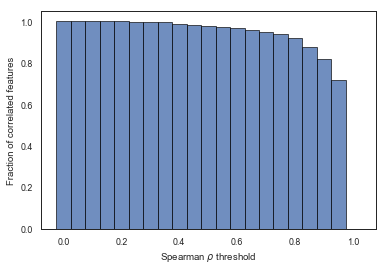

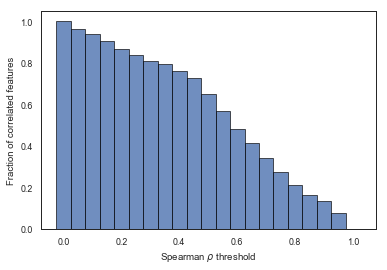

In [7]:
correlation_pipeline(features_lung1, os.path.join(results_path, 'lung1', 'correlations'))

### HeadNeck1

/Users/michalmacbook/anaconda3/envs/maastro36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


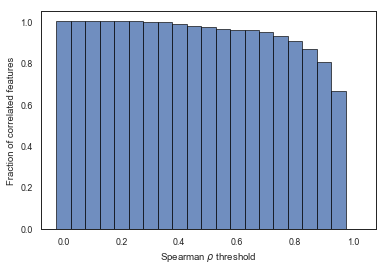

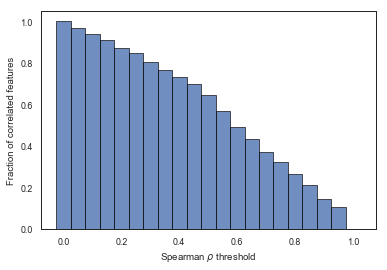

In [8]:
correlation_pipeline(features_hn1, os.path.join(results_path, 'hn1', 'correlations'))

## Clustering
Section 3.2 in the paper, figure 2.

In [9]:
def hierarchical_cluster(features, n_clusters):
    pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('cluster', AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'))
    ])
    return pipeline.fit_predict(features)

def cluster_volume_distribution(volume, cluster_labels, colours=None):
    fig, ax = plt.subplots()
    volume_df = pd.DataFrame({'volume': volume, 'cluster': cluster_labels + 1})
    ax = sns.boxplot(data=volume_df, x='cluster', y='volume', ax=ax, palette=colours)
    return ax

def cluster_survival_distribution(cluster_labels, survival_time, event, colours=None, show_stats=True, **kwargs):
    kmf = KaplanMeierFitter()
    
    fig, ax = plt.subplots()
    for i in range(cluster_labels.max() + 1):
        kmf.fit(survival_time[cluster_labels == i], event[cluster_labels == i], label=f'cluster {i + 1}')
        ax = kmf.plot(ax=ax, c=colours[i], **kwargs)

    ax.set_ylabel('survival probability')
    if cluster_labels.max() >= 2:
        lrtest = pairwise_logrank_test(survival_time, cluster_labels, event)
    else:
        lrtest = [[
            None,
            logrank_test(survival_time[cluster_labels == 0],
                         survival_time[cluster_labels == 1],
                         event[cluster_labels == 0],
                         event[cluster_labels == 1])
        ]]

    return ax, lrtest

def volume_correlation(features):
    return features.corr(method='spearman')['original_shape_Volume']
    
def volume_threshold(features, threshold, volume_corr):
    """Remove features correlated with volume at a given threshold."""
    return features.loc[:, volume_corr.abs() < threshold].drop('original_shape_Volume', axis=1, errors='ignore')

def permutation_test(variable, labels, n_iter=1000):
    """Evaluate significance of difference between 2 groups using
    a randomized permutation test.
    """
    perm = labels.copy()
    diffs = []
    for _ in range(n_iter):
        perm = np.random.permutation(perm)
        c0p = variable[perm == 0]
        c1p = variable[perm == 1]
        diffs.append(c0p.mean() - c1p.mean())
    observed_diff = variable[labels == 0].mean() - variable[labels == 1].mean()
    return (np.sum(np.abs(diffs) > np.abs(observed_diff)) + 1) / (n_iter + 1)

### Cluster separation by volume only (figure 2b).

<lifelines.StatisticalResult: 

t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p     
       22.9733 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
>


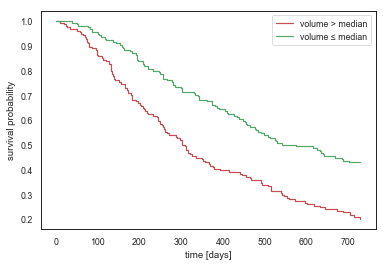

In [10]:
med_volume = features_lung1["original_shape_Volume"].median()
labels = features_lung1["original_shape_Volume"] <= med_volume
survival_time = np.where(clinical_lung1['survival_time'] < 730, clinical_lung1['survival_time'], 730)
event = clinical_lung1["two_year_survival"]
kmf = KaplanMeierFitter()

fig, ax = plt.subplots()
kmf.fit(survival_time[labels == 0], event[labels == 0], label='volume > median')
ax = kmf.plot(ax=ax, c='r', ci_show=False)
kmf.fit(survival_time[labels == 1], event[labels == 1], label='volume ≤ median')
ax = kmf.plot(ax=ax, c='g', ci_show=False)

ax.set_xlabel('time [days]')
ax.set_ylabel('survival probability')
fig.savefig(os.path.join(results_path, 'lung1', 'survival_volume.pdf'))

lrtest = logrank_test(survival_time[labels == 0],
                      survival_time[labels == 1],
                      event[labels == 0],
                      event[labels == 1])

print(lrtest)

In [11]:
def clustering_pipeline(features, clinical, output_path):
    """Run the clustering experiment described in section 2.4."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    volume = features['original_shape_Volume']
    volume_corr = volume_correlation(features)
    statistics_results = []
    for t in [1.1, .75, .6, .1]:
        clusters = hierarchical_cluster(volume_threshold(features, t, volume_corr), 2)
        cluster_med_survival = [clinical.loc[clusters == i, 'survival_time'].median() for i in range(clusters.max() + 1)]
        if cluster_med_survival[0] > cluster_med_survival[1]:
            clusters = np.where(clusters == 1, 0, 1)
        colours = np.array(['r', 'g', 'b', 'y'])
        survival_ax, lr_test = cluster_survival_distribution(clusters, clinical['two_year_survival_time'], clinical['two_year_survival'], colours=colours, ci_show=False)
        survival_ax.figure.savefig(os.path.join(output_path, f'clustering_threshold_{str(round(t, 2)).replace(".", "")}_survival.pdf'))
        volume_ax = cluster_volume_distribution(volume, clusters, colours)
        volume_ax.figure.savefig(os.path.join(output_path, f'clustering_threshold_{str(round(t, 2)).replace(".", "")}_volume.pdf'))
        volume_pval = permutation_test(volume, clusters)         
        statistics_results.append({'threshold': t, 'logrank_pval': lr_test[0][1].p_value, 'volume_pval': volume_pval})
    pd.DataFrame(statistics_results).to_csv(os.path.join(output_path, 'statistics.csv'))

### Lung1

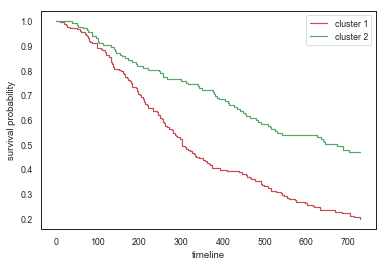

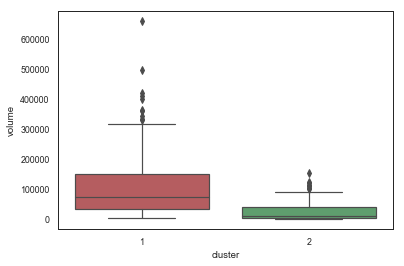

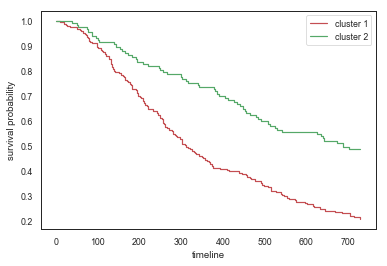

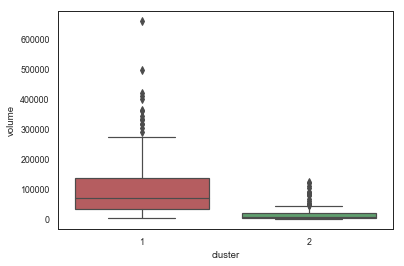

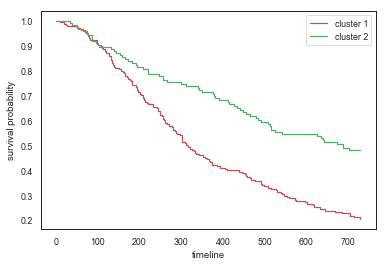

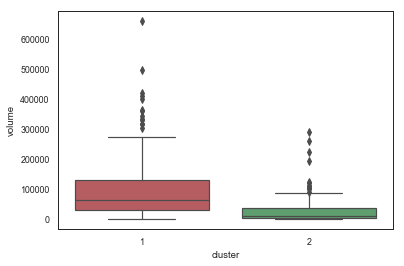

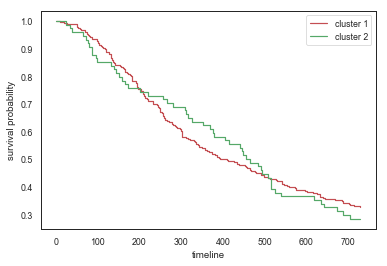

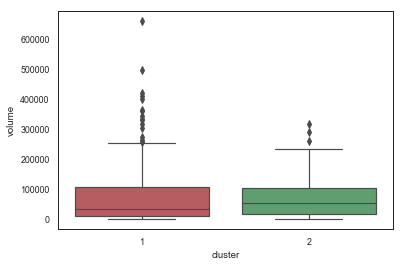

In [12]:
clustering_pipeline(features_lung1, clinical_lung1, os.path.join(results_path, 'lung1', 'clustering'))

### HeadNeck1

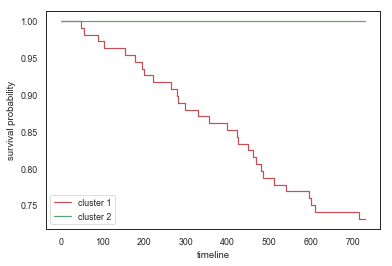

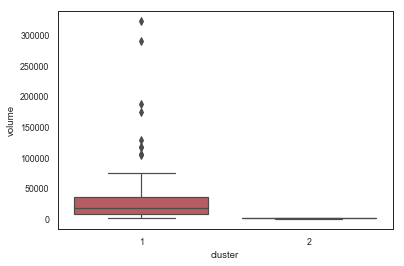

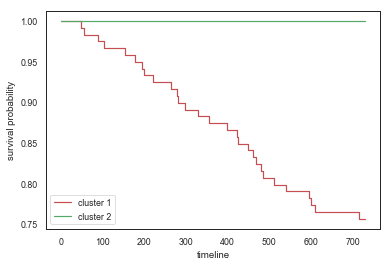

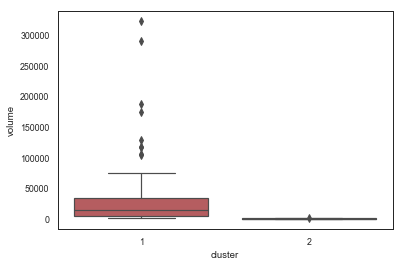

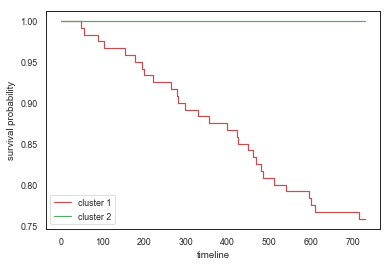

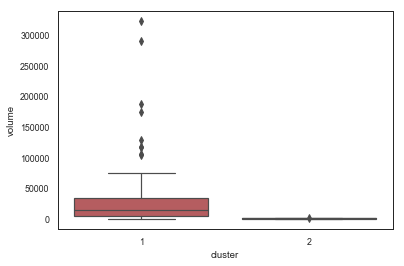

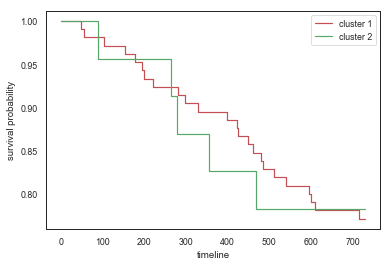

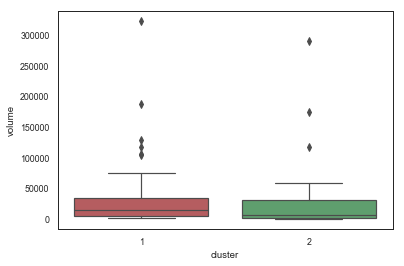

In [13]:
clustering_pipeline(features_hn1, clinical_hn1, os.path.join(results_path, 'hn1', 'clustering'))

## Principal component analysis
Section 3.2 in the paper, figure 3.

In [14]:
def plot_pca(features, volume):
    pipeline = Pipeline([
        ('scale', StandardScaler())
        ('pca', PCA(n_components=2))
    ])
    features_pca = pipeline.fit_transform(features)
    exp_var_1, exp_var_2 = pipeline.named_steps.pca.explained_variance_ratio_
    ax = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=np.log(volume), cmap='Spectral')
    ax.set_xlabel(f'PC 1 ({round(exp_var_1, 1)})')
    ax.set_xlabel(f'PC 2 ({round(exp_var_2, 1)})')
    plt.colorbar()
    return features_pca, ax

In [15]:
def pca_pipeline(features, output_path):
    """Run the clustering experiment described in section 2.5."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    volume = features['original_shape_Volume']
    volume_corr = volume_correlation(features)
    corrs = []
    for t in [1.1, .75, .6, .1]:
        pipeline = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=2))
        ])
        fig, ax = plt.subplots()
        features_pca = pipeline.fit_transform(volume_threshold(features, t, volume_corr))
        exp_var_1, exp_var_2 = pipeline.named_steps.pca.explained_variance_ratio_
        scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], c=np.log(volume), cmap='Spectral')
        ax.set_xlabel(f'PC 1 ({round(exp_var_1 * 100, 1)}%)')
        ax.set_ylabel(f'PC 2 ({round(exp_var_2 * 100, 1)}%)')
        fig.colorbar(scatter, ax=ax, label='$\log(V)$')

        fig.tight_layout()
        fig.savefig(os.path.join(output_path, f'pca_threshold_{str(round(t, 2)).replace(".", "")}.pdf'))
        
        corrs.append({'threshold': t, 'PC': 1, 'spearman': spearmanr(features_pca[:, 0], volume)})
        corrs.append({'threshold': t, 'PC': 2, 'spearman': spearmanr(features_pca[:, 1], volume)})
    
    pd.DataFrame(corrs).to_csv(os.path.join(output_path, 'pc_correlations.csv'))

### Lung1

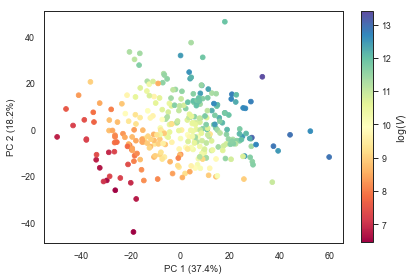

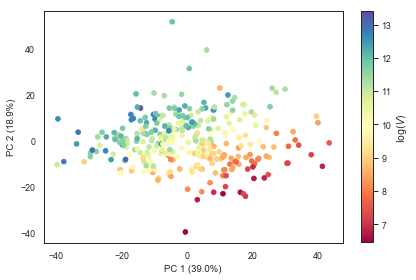

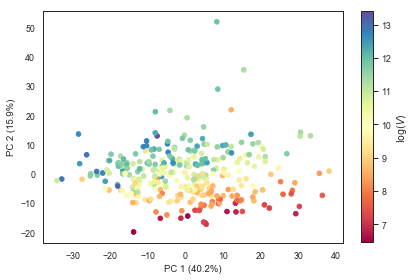

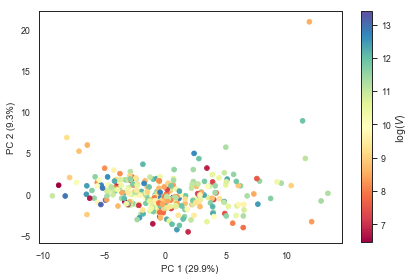

In [16]:
pca_pipeline(features_lung1, os.path.join(results_path, 'lung1', 'pca'))

### HeadNeck1

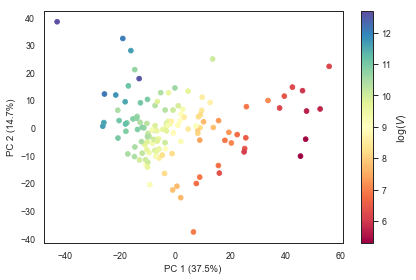

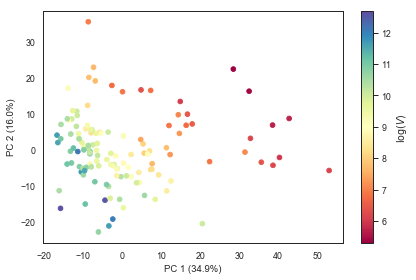

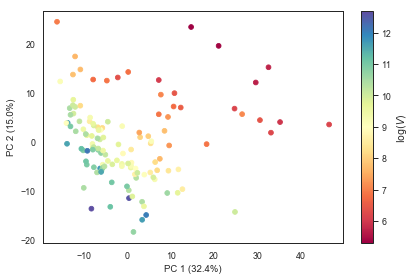

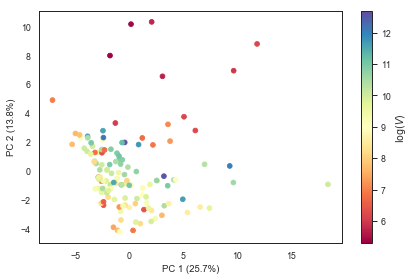

In [17]:
pca_pipeline(features_hn1, os.path.join(results_path, 'hn1', 'pca'))

### HeadNeckMR

In [ ]:
pca_pipeline(features_hn_mr, os.path.join(results_path, 'hn_mr', 'pca'))

## Modelling survival & feature importance
Section 3.3 in the paper, figure 4.

In [18]:
"""
Logistic regression with bootstrap feature importance based on [1]_.
Note that this implementation uses recursive feature elimination as opposed to 
stepwise selection used in the original publication.

References
----------
.. [1] I. El Naqa et al., ‘Multivariable modeling of radiotherapy outcomes, 
   including dose–volume and clinical factors’, International Journal of Radiation Oncology*Biology*Physics,
   vol. 64, no. 4, pp. 1275–1286, Mar. 2006, doi: 10.1016/j.ijrobp.2005.11.022.
"""
def bootstrap_resample(x, n=None):
    """Resample dataset by bootstrapping."""
    if not n: 
        n = x.shape[0]
    idxs = np.arange(x.shape[0])
    return np.random.choice(idxs, replace=True, size=n)

def resample_iter(pipeline_rfe, features, target):
    """Perform one iteration of feature selection with bootstrap resampling."""
    resample_idxs = bootstrap_resample(features)
    x_train, y_train = features.iloc[resample_idxs], target.iloc[resample_idxs]
    pipeline_rfe.fit(x_train, y_train)
    return pipeline_rfe.named_steps.rfe.ranking_

def bootstrap_feature_stability(estimator, features, target, n_iter=1000, n_jobs=1):
    """Evaluate feature stability for a supervised task using bootstrap resampling."""
    pipeline_rfe = Pipeline([
        ('scale', StandardScaler()),
        ('rfe', RFE(estimator, n_features_to_select=1))
    ])
    feature_orders = Parallel(n_jobs)(
        delayed(resample_iter)(pipeline_rfe, features, target) for _ in trange(n_iter))
    return pd.DataFrame(np.array(list(feature_orders)).T, columns=range(n_iter), index=features.columns)

def plot_resample_orders(feature_orders, thin=1):
    """Plot the order of entering the model for each variable across
    bootstrap iterations.
    """
    fig, ax = plt.subplots(len(feature_orders))
    for (feature, orders), a in zip(feature_orders.iloc[:, ::thin].iterrows(), ax):
        a.bar(np.arange(len(orders)), 1 / orders, color='black', edgecolor='black')
        a.set_ylabel(feature, rotation=0, fontsize=8, horizontalalignment='right', verticalalignment='center')
        a.set_ylim(0, 1)
        a.set_yticklabels([])
    ax[-1].set_xlabel('bootstrap iteration')
    fig.tight_layout()
    return ax

def plot_top_frequency(feature_orders):
    """Plot the top features by frequency of entering the model first."""
    fig, ax = plt.subplots()
    ax.barh(np.arange(feature_orders.shape[0]), np.sum(feature_orders == 1, axis=1) / feature_orders.shape[1], color='k')
    ax.set_xlim(0, 1)
    ax.set_xlabel('frequency entering first')
    ax.set_yticks(range(feature_orders.shape[0]))
    ax.set_yticklabels(feature_orders.index, rotation=0, fontsize=8)
    ax.invert_yaxis()
    fig.tight_layout()
    return ax

In [19]:
def modelling_pipeline(features, clinical, output_path):
    """Run the modelling experiment described in section 2.6."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    logistic = LogisticRegressionCV(class_weight='balanced', # dataset has fewer positive samples 
                                    scoring='neg_log_loss',
                                    solver='sag')            # SAG solver is faster than the default, useful for mutliple iterations
    # remove volume correlated features
    features_vol = volume_threshold(features, .1, volume_correlation(features))
    features_vol['original_shape_Volume'] = features['original_shape_Volume']
    X = features_vol.join(clinical.drop(['survival_time', 'death_status', 'two_year_survival', 'two_year_survival_time'], axis=1))
    y = clinical['two_year_survival']
    feature_orders = bootstrap_feature_stability(logistic, X, y, n_jobs=7)
    ax = plot_resample_orders(feature_orders, thin=1)
    ax[0].figure.savefig(os.path.join(output_path, 'feature_orders.pdf'))
    ax = plot_top_frequency(feature_orders)
    ax.figure.savefig(os.path.join(output_path, 'top_frequency.pdf'))

### Lung1

100%|██████████| 1000/1000 [01:25<00:00, 11.63it/s]
/Users/michalmacbook/anaconda3/envs/maastro36/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


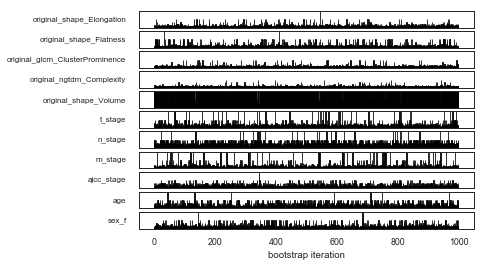

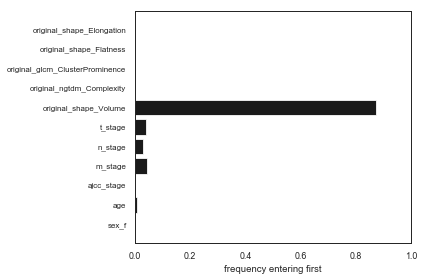

In [20]:
modelling_pipeline(features_lung1.filter(like='original'), clinical_lung1, os.path.join(results_path, 'lung1', 'survival_prediction'))

### HeadNeck1

100%|██████████| 1000/1000 [02:09<00:00,  7.11it/s]
/Users/michalmacbook/anaconda3/envs/maastro36/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


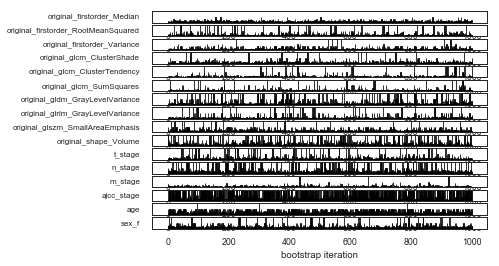

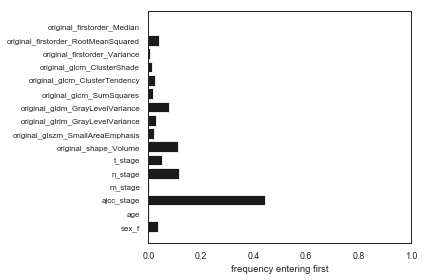

In [21]:
modelling_pipeline(features_hn1.filter(like='original'), clinical_hn1, os.path.join(results_path, 'hn1', 'survival_prediction'))

### HeadNeckMR

In [ ]:
modelling_pipeline(features_hn_mr.filter(like='original'), clinical_hn_mr, os.path.join(results_path, 'hn_mr', 'survival_prediction'))